## Assignment 2- Submission 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings


# from skimage import data, feature

warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
from skimage import io, color, transform, feature, exposure
# from skimage.feature import corner_foerstner
from my_measures import BinaryClassificationPerformance  
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using BinaryClassificationPerformance v1.03


In [3]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.03
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

### file paths and names

In [4]:
ci_path = 'plane_data/cropped_images/' # file path for cropped images for training
l_file = 'plane_data/plane_labels.csv' # file path and file name for csv with labels

# Function for feature building and extraction on photographs¶

scikit-image documentation on methods used for feature extraction:  

* http://scikit-image.org/docs/dev/api/skimage.color.html#rgb2gray  
* http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize  
* http://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.canny

In [5]:
# in downscaling the image, what do you want the new dimensions to be?
# the original dimensions of cropped images: (60, 140), which if 8,400 pixels
dims = (15, 35) # 25% of the original size, 525 pixels

##### Switching back to Corner Shi Tomasi: detects corners, makes it pixelated

Changed sigma value to .9

downscaled image shape: 
(15, 35)
image representation (first row of pixels): 
[0.03100094 0.02781766 0.00900903 0.00848834 0.0086885  0.0060433
 0.00309791 0.00120994 0.00133847 0.00210045 0.00307054 0.00412528
 0.00382256 0.00195528 0.00104872 0.0014428  0.00233585 0.00455918
 0.00495776 0.00444744 0.00791922 0.01031715 0.00728795 0.0033921
 0.0014561  0.00179082 0.00448576 0.01167653 0.02317017 0.03991389
 0.03717357 0.02070402 0.01919822 0.03872653 0.04061313]


example of transformation: 


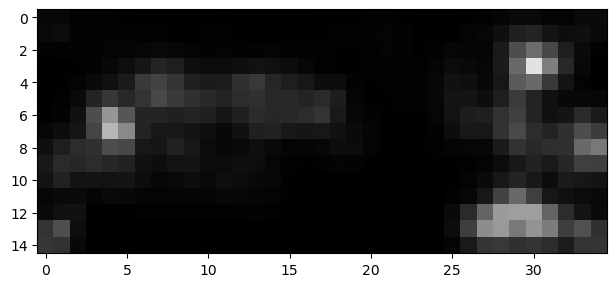

In [6]:
def image_manipulation(imname, imgs_path, imview=False):
    warnings.filterwarnings('ignore')
    imname = imgs_path + imname + '.png'
    img_raw = io.imread(imname, as_gray=True)
    downscaled = transform.resize(image = img_raw, output_shape = (dims[0], dims[1]), anti_aliasing=True, order =5) # downscale image 
    
# adding more manipulations
    #rotated = transform.rotate(img_raw, 15, resize=False, center=None, order=None, mode='constant', cval=0, clip=True, preserve_range=False)
    hough = transform.hough_line(downscaled, theta=None)
    exposed = exposure.adjust_gamma(downscaled, gamma=0.5, gain=1)
#     pyramid = transform.pyramid_laplacian(downscaled, max_layer=-1, downscale=2, sigma=None, order=1, mode='symmetric', cval=0, preserve_range=False, channel_axis=None)

#corner moravec
#     final_image = feature.corner_moravec(downscaled, window_size=1)
#     final_image = feature.corner_moravec(img_raw, window_size=1)
    final_image = feature.corner.corner_shi_tomasi(downscaled,sigma=.9)
    

    if imview==True:
        io.imshow(final_image)
    warnings.filterwarnings('always')
    return final_image

# test the function, look at input/output
test_image = image_manipulation('2017-08-25T23+24+13_390Z', ci_path, True)
# test_image = image_manipulation('2016-12-04T14+31+37_880Z', ci_path, True) #different image to test out

print('downscaled image shape: ')
# print('original image shape: ')
print(test_image.shape)
print('image representation (first row of pixels): ')
print(test_image[0])
print('\n')
print('example of transformation: ')

for comparison, look at original image:

/Users/juwonlee/opt/anaconda3/lib/python3.9/site-packages/skimage/io/_plugins/imageio_plugin.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  return np.asarray(imageio_imread(*args, **kwargs))


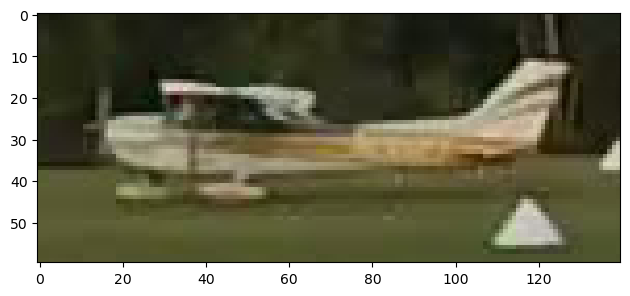

In [7]:
this_imname = ci_path + '2017-08-25T23+24+13_390Z.png'
io.imshow(io.imread(this_imname))

# function to process raw images, resulting in training and test datasets

In [8]:
# function that takes raw images and completes all preprocessing required before model fits
def process_raw_data(labels_fn, images_fp, my_random_seed, imview=False, test=False):
    plane_data = pd.read_csv(labels_fn) # read in photograph labels
    print("First few lines of image labels: ")
    print(plane_data.head())
    print("Size of image label dataFrame: ")
    print(plane_data.shape)
        
    # construct lists for features, labels, and a crosswalk reference to image names
    features_list = []
    if (not test):
        y_list = []
    imnames_list = []

    for index, row in plane_data.iterrows():
        features_list.append(image_manipulation(row['img_name'], images_fp))
        if (not test):
            y_list.append(row['plane'])
        imnames_list.append(row['img_name'])
    
    # convert the lists to ndarrays
    features = np.asarray(features_list)
    if (not test):
        Y = np.asarray(y_list)
    imgs = np.asarray(imnames_list)
    print('Shape of original feature representation: ')
    print(features.shape)

    # flatten the images ndarray to one row per image
    features_flat = features.reshape((features.shape[0], -1))

    print('Shape of flat feature representation: ')
    print(features_flat.shape)

    if (not test):
        print('Shape of Y: ')
        print(Y.shape)

        print('Number of images with planes: ')
        print(Y.sum())
    
        # create train and test sets
        data_train, data_test, y_train, y_test, imgs_train, imgs_test = train_test_split(features_flat, 
            Y, imgs, test_size = 0.25, random_state = my_random_seed)

        print('Shape of training set: ')
        print(y_train.shape)
        print('Number of training images that contain an airplane: ')
        print(y_train.sum())

        print('Shape of test set: ')
        print(y_test.shape)
        print('Number of test images that contain an airplane: ')
        print(y_test.sum())
    
    if (test):
        X_submission_test = features_flat
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(X_submission_test, plane_data)
    else: 
        print("Shape of data_train and data_test:")
        print(data_train.shape)
        print(data_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of imgs_train and imgs_test:")
        print(imgs_train.shape)
        print(imgs_test.shape)
        print('SUCCESS!')
        return(data_train, data_test, y_train, y_test, imgs_train, imgs_test)


In [9]:
data_train, data_test, y_train, y_test, imgs_train, imgs_test = process_raw_data(l_file, ci_path, 
    my_random_seed=63, imview=False, test=False)

First few lines of image labels: 
                   img_name  plane
0  2016-08-02T13+50+24_430Z  False
1  2016-08-02T14+12+37_390Z  False
2  2016-08-02T22+20+26_600Z  False
3  2016-08-03T12+04+30_670Z  False
4  2016-08-03T12+32+21_790Z  False
Size of image label dataFrame: 
(6758, 2)
Shape of original feature representation: 
(6758, 15, 35)
Shape of flat feature representation: 
(6758, 525)
Shape of Y: 
(6758,)
Number of images with planes: 
101
Shape of training set: 
(5068,)
Number of training images that contain an airplane: 
80
Shape of test set: 
(1690,)
Number of test images that contain an airplane: 
21
Shape of data_train and data_test:
(5068, 525)
(1690, 525)
Shape of y_train and y_test:
(5068,)
(1690,)
Shape of imgs_train and imgs_test:
(5068,)
(1690,)
SUCCESS!


# train Perceptron

In [10]:
# MODEL: Perceptron
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(data_train, y_train)

prc_performance = BinaryClassificationPerformance(prc.predict(data_train), y_train, 'prc')
prc_performance.compute_measures()
prc_performance.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(prc_performance.performance_measures)

prc_performance_test = BinaryClassificationPerformance(prc.predict(data_test), y_test, 'prc')
prc_performance_test.compute_measures()
prc_performance_test.performance_measures['set'] = 'test'
print('TEST SET: ')
print(prc_performance_test.performance_measures)

prc_performance_test.img_indices()
prc_img_indices_to_view = prc_performance_test.image_indices

TRAINING SET: 
{'Pos': 80, 'Neg': 4988, 'TP': 70, 'TN': 4985, 'FP': 3, 'FN': 10, 'Accuracy': 0.9974348855564326, 'Precision': 0.958904109589041, 'Recall': 0.875, 'desc': 'prc', 'set': 'train'}
TEST SET: 
{'Pos': 21, 'Neg': 1669, 'TP': 15, 'TN': 1663, 'FP': 6, 'FN': 6, 'Accuracy': 0.9928994082840237, 'Precision': 0.7142857142857143, 'Recall': 0.7142857142857143, 'desc': 'prc', 'set': 'test'}


In [11]:
def performance_examples(typ, measures):
    iiv = ''
    if typ == 'FP':
        iiv = typ + '_indices'
    elif typ == 'TP':
        iiv = typ + '_indices'
    elif typ == 'FN':
        iiv = typ + '_indices'
    else:
        raise ValueError('input must be "TP", "FP", or "FN"')
    for img in measures[iiv]:
        warnings.filterwarnings('ignore')    
        plt.figure()
        lookat = ci_path + imgs_test[img] + '.png' # location of original image
        io.imshow(lookat) # show original image
        plt.figure()
        io.imshow(data_test[img].reshape(dims[0], dims[1])) # show manipulation for feature representation
#         io.imshow(data_test[img])
        warnings.filterwarnings('always')


# look at examples of Perceptron classifications

## true positives

In [ ]:
performance_examples('TP', prc_img_indices_to_view)

## false positives

In [ ]:
performance_examples('FP', prc_img_indices_to_view)

## false negatives

In [ ]:
performance_examples('FN', prc_img_indices_to_view)

# train Multilayer Perceptron, a.k.a. neural network

Kept last iterations hidden layer sizes, but also added a couple more that may be more fitting for this size of data.

In [12]:
# MODEL: Multi-layer Perceptron aka neural network

from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes = (20,100,100,75), max_iter=1000)
print(nn)
nn.fit(data_train, y_train)

nn_performance = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance.compute_measures()
nn_performance.performance_measures['set'] = 'train'
print('TRAINING SET: 20,100,100,75')
print(nn_performance.performance_measures)

nn_performance_test = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test.compute_measures()
nn_performance_test.performance_measures['set'] = 'test'
print('TEST SET: 20,100,100,75')
print(nn_performance_test.performance_measures)

nn_performance_test.img_indices()
nn_img_indices_to_view = nn_performance_test.image_indices

MLPClassifier(hidden_layer_sizes=(20, 100, 100, 75), max_iter=1000)
TRAINING SET: 20,100,100,75
{'Pos': 80, 'Neg': 4988, 'TP': 80, 'TN': 4988, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'nn', 'set': 'train'}
TEST SET: 20,100,100,75
{'Pos': 21, 'Neg': 1669, 'TP': 16, 'TN': 1666, 'FP': 3, 'FN': 5, 'Accuracy': 0.9952662721893492, 'Precision': 0.8421052631578947, 'Recall': 0.7619047619047619, 'desc': 'nn_test', 'set': 'test'}


In [13]:
# MODEL: Multi-layer Perceptron aka neural network

from sklearn import neural_network
nn1 = neural_network.MLPClassifier(hidden_layer_sizes = (5, 5, 10), max_iter=1000)
print(nn1)
nn1.fit(data_train, y_train)

nn1_performance = BinaryClassificationPerformance(nn1.predict(data_train), y_train, 'nn1')
nn1_performance.compute_measures()
nn1_performance.performance_measures['set'] = 'train'
print('TRAINING SET: 5, 5, 10')
print(nn1_performance.performance_measures)

nn1_performance_test = BinaryClassificationPerformance(nn1.predict(data_test), y_test, 'nn1_test')
nn1_performance_test.compute_measures()
nn1_performance_test.performance_measures['set'] = 'test'
print('TEST SET:  5, 5, 10')
print(nn1_performance_test.performance_measures)

nn1_performance_test.img_indices()
nn1_img_indices_to_view = nn1_performance_test.image_indices

MLPClassifier(hidden_layer_sizes=(5, 5, 10), max_iter=1000)
TRAINING SET: 5, 5, 10
{'Pos': 80, 'Neg': 4988, 'TP': 79, 'TN': 4988, 'FP': 0, 'FN': 1, 'Accuracy': 0.999802683504341, 'Precision': 1.0, 'Recall': 0.9875, 'desc': 'nn1', 'set': 'train'}
TEST SET:  5, 5, 10
{'Pos': 21, 'Neg': 1669, 'TP': 17, 'TN': 1665, 'FP': 4, 'FN': 4, 'Accuracy': 0.9952662721893492, 'Precision': 0.8095238095238095, 'Recall': 0.8095238095238095, 'desc': 'nn1_test', 'set': 'test'}


In [14]:
# MODEL: Multi-layer Perceptron aka neural network

from sklearn import neural_network
nn2 = neural_network.MLPClassifier(hidden_layer_sizes = (50,38,16), max_iter=1000)
print(nn2)
nn2.fit(data_train, y_train)

nn2_performance = BinaryClassificationPerformance(nn2.predict(data_train), y_train, 'nn2')
nn2_performance.compute_measures()
nn2_performance.performance_measures['set'] = 'train'
print('TRAINING SET: 50,38,16')
print(nn2_performance.performance_measures)

nn2_performance_test = BinaryClassificationPerformance(nn2.predict(data_test), y_test, 'nn2_test')
nn2_performance_test.compute_measures()
nn2_performance_test.performance_measures['set'] = 'test'
print('TEST SET: 50,38,16')
print(nn2_performance_test.performance_measures)

nn2_performance_test.img_indices()
nn2_img_indices_to_view = nn2_performance_test.image_indices

MLPClassifier(hidden_layer_sizes=(50, 38, 16), max_iter=1000)
TRAINING SET: 10,8,6
{'Pos': 80, 'Neg': 4988, 'TP': 80, 'TN': 4988, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'nn2', 'set': 'train'}
TEST SET: 10,8,6
{'Pos': 21, 'Neg': 1669, 'TP': 17, 'TN': 1663, 'FP': 6, 'FN': 4, 'Accuracy': 0.9940828402366864, 'Precision': 0.7391304347826086, 'Recall': 0.8095238095238095, 'desc': 'nn2_test', 'set': 'test'}


# look at examples of neural network classifications

## true positives

In [ ]:
performance_examples('TP', nn_img_indices_to_view)

## false positives

In [ ]:
performance_examples('FP', nn_img_indices_to_view)

## false negatives

In [ ]:
performance_examples('FN', nn_img_indices_to_view)

# comparisons

In [15]:
# list of fits to compare: 
final_fits = []
final_fits.append(prc_performance.performance_measures)
final_fits.append(prc_performance_test.performance_measures)
final_fits.append(nn_performance.performance_measures)
final_fits.append(nn_performance_test.performance_measures)
final_fits.append(nn1_performance.performance_measures)
final_fits.append(nn1_performance_test.performance_measures)
final_fits.append(nn2_performance.performance_measures)
final_fits.append(nn2_performance_test.performance_measures)

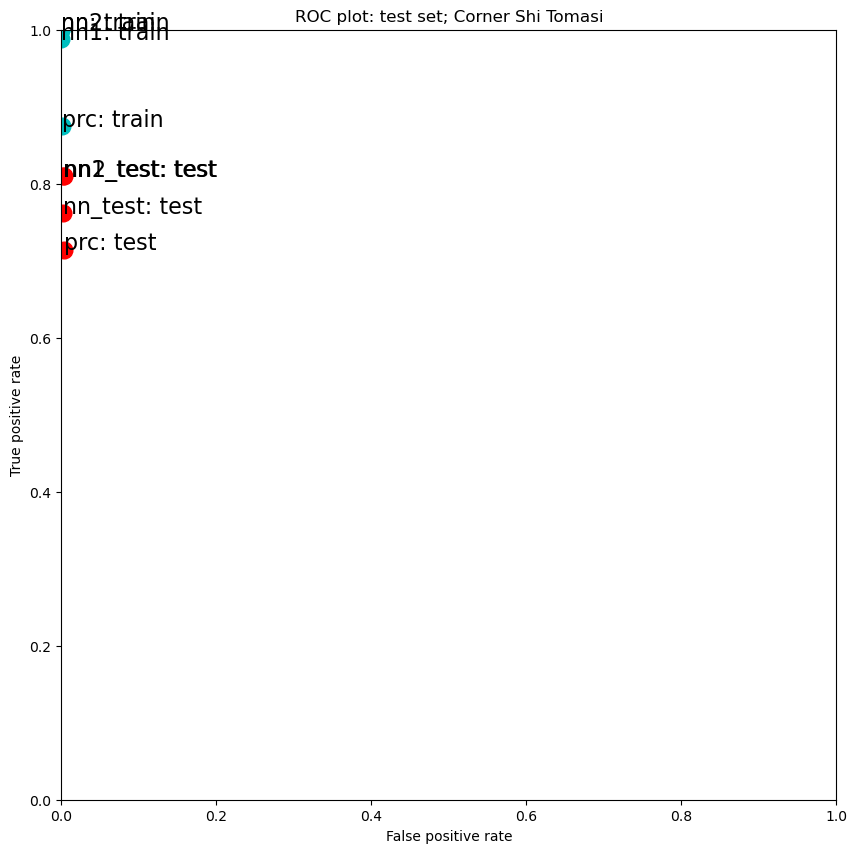

In [16]:
plt.figure(figsize=(10,10))

for fit in final_fits:
    if fit['set'] == 'train':
        color = 'co'
    else:
        color = 'ro'
    plt.plot(fit['FP'] / fit['Neg'], 
             fit['TP'] / fit['Pos'], color, markersize=12)
    plt.text(fit['FP'] / fit['Neg'], 
             fit['TP'] / fit['Pos'], fit['desc'] + ': ' + fit['set'], fontsize=16)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set; Corner Shi Tomasi')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()


# SUBMISSION

### file paths and names:

The only main change we made in this iteration is swapping out the corner moravec to corner shi tomasi and updating the sigma value to .9. Yet, everytime I run the training and test data sets, the performance (espeically on the plot chart above) fluctuates significantly. We understand that every run will have a different output, but at one point, my prc test data performance jumped up to TP .94 and FP .03 area despite the precision rate for the test data reading as .39 and us not making any changes to the percepton model. Not sure what's happening, but would love to see how it performs and chat through :/

In [17]:
submission_ci_path = 'test_data_for_grading/test_cropped_images/' # file path for cropped images for training
submission_l_file = 'test_data_for_grading/test_plane_labels.csv' # file path and file name for csv with labels

In [18]:
X_test_data, X_test_submission = process_raw_data(submission_l_file, submission_ci_path, my_random_seed=63, test=True)
print("Number of rows in the submission test set (should be 1,523): ")

First few lines of image labels: 
                   img_name
0  2016-08-02T13+50+24_430Z
1  2016-08-02T14+12+37_390Z
2  2016-08-03T12+32+21_790Z
3  2016-08-03T13+19+28_320Z
4  2016-08-05T15+24+58_670Z
Size of image label dataFrame: 
(1523, 1)
Shape of original feature representation: 
(1523, 15, 35)
Shape of flat feature representation: 
(1523, 525)
Shape of X_test for submission:
(1523, 525)
SUCCESS!
Number of rows in the submission test set (should be 1,523): 


### IMPORTANT CHECK: make sure that the number of columns in your training data is the same as the number of columns in this test submission!

In [19]:
print(data_train.shape)
print(X_test_data.shape)

(5068, 525)
(1523, 525)


Both the training set and submission test set have 525 columns. Success!

---

Choose a *single* model for your submission. In this code, I am choosing the Perceptron model fit, which is in the prc object. But you should choose the model that is performing the best for you!

Choosing Neural Network model (nn1) based on the performance above! With hidden_layer_sizes = (1030,555,120)

In [20]:
# concatenate predictions to the id
X_test_submission["prediction"] = nn1.predict(X_test_data)
# look at the proportion of positive predictions
print(X_test_submission['prediction'].mean())

0.014445173998686802


This is the proportion of predictions that have predicted that there is an airplane in the image.

In [21]:
print(X_test_submission.shape) # should be (1523, 2)

(1523, 2)


In [22]:
# export submission file as pdf
# CHANGE FILE PATH: 
X_test_submission.to_csv('airplane_submission2.csv', index=False)